In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection as cv
import math
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import gzip
from sklearn.preprocessing import OneHotEncoder

In [2]:
iris = pd.read_csv("iris.csv")

In [3]:
iris.loc[iris["species"]=="setosa","species"]=0
iris.loc[iris["species"]=="versicolor","species"]=1
iris.loc[iris["species"]=="virginica","species"]=2

In [4]:
x_train, x_test, y_train, y_test = cv.train_test_split(iris.iloc[:,1:4], iris.iloc[:,4], test_size=0.30, random_state=50)

In [5]:
x_train = x_train.as_matrix()
x_test = x_test.as_matrix()

In [6]:
y_test = pd.get_dummies(y_test).as_matrix()
y_train = pd.get_dummies(y_train).as_matrix()

In [7]:
class NeuralNet():
    def __init__(self, train, target, x_test, y_test, hidden_layers = 2, neu_hid_layer = 6, learning_rate=0.5, epoch=20000):
        self.train = train # This is a training data set
        self.target = target # This is target column that needs to be predicted
        self.hidden_layers = hidden_layers 
        self.neu_hid_layer = neu_hid_layer 
        self.in_layer = train.shape[1] 
        self.op_ly = 3
        self.learning_rate = learning_rate 
        self.epoch = epoch
        self.x_test = x_test
        self.y_test = y_test
        self.predicted = None
        self.test_pred = None
        self.sig = []
        self.sig_der = []
        self.zvalue = []
        
        if self.hidden_layers == 1:
        # Initializing Random Weights
            self.wt_ly1 = np.random.randn(self.in_layer, self.neu_hid_layer)
            self.b_ly1 = np.ones((1, self.neu_hid_layer))
            self.wt_ly2 = np.random.randn(self.neu_hid_layer, self.op_ly)
            self.b_ly2 = np.ones((1, self.op_ly))
        
        elif self.hidden_layers == 2:
            self.wt_ly1 = np.random.randn(self.in_layer, self.neu_hid_layer)
            self.b_ly1 = np.ones((1, self.neu_hid_layer))
            self.wt_ly2 = np.random.randn(self.neu_hid_layer, self.neu_hid_layer)
            self.b_ly2 = np.ones((1, self.neu_hid_layer))
            self.wt_ly3 = np.random.randn(self.neu_hid_layer, self.op_ly)
            self.b_ly3 = np.ones((1, self.op_ly))
            
        
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def softmax(self, z):
        scoreMatExp = np.exp(z)
        return scoreMatExp / scoreMatExp.sum(0)
    
    
    def gradient_descent(self, tdelta1, tdelta2, tb1, tb2, tdelta3=0, tb3=0): ## Need to see what can be done here
        if self.hidden_layers == 1:
            self.wt_ly1 = self.wt_ly1 - (self.learning_rate*tdelta1)
            self.wt_ly2 = self.wt_ly2 - (self.learning_rate * tdelta2)
            self.b_ly1 = self.b_ly1 - self.learning_rate*tb1
            self.b_ly2 = self.b_ly2 - self.learning_rate*tb2
        
        elif self.hidden_layers == 2:
            self.wt_ly1 = self.wt_ly1 - (self.learning_rate*tdelta1)
            self.wt_ly2 = self.wt_ly2 - (self.learning_rate * tdelta2)
            self.wt_ly3 = self.wt_ly3 - (self.learning_rate * tdelta3)
            self.b_ly1 = self.b_ly1 - self.learning_rate*tb1
            self.b_ly2 = self.b_ly2 - self.learning_rate*tb2
            self.b_ly3 = self.b_ly3 - self.learning_rate*tb3
    
    def propogation(self, instance):
        sig = []
        sig_der = []
        zvalue = []
        if self.hidden_layers == 1:
            # Forward Propogation
            a1 = np.array(self.train)
            z2 = np.dot(instance, self.wt_ly1)
            a2 = self.activation(z2)
            z3 = np.dot(a2, self.wt_ly2)
            a3 = self.activation(z3)
            error = a3 - inst.target
           
            sig.append(a3)
            sig_der.append(a3*(1-a3))
            zvalue.append(z3)
            self.sig = sig
            self.sig_der = sig_der
            self.zvalue = zvalue
        
            #Backward Propogation to find derivative
            delta2 = error * a3 * (1-a3)
            delta1 = np.dot(delta2,  self.wt_ly2.T) * a2 * (1-a2) #a2*(1-a2) is derivative of sigmoid function
            tdelta2 = np.dot(a2.T, delta2)
            tdelta1 = np.dot(instance.T, delta1)
            tb2 = np.sum(delta2, axis=0).reshape(np.shape(self.b_ly2))
            tb1 = np.sum(delta1, axis=0).reshape(np.shape(self.b_ly1))

            # adjust weights by gradient descent
            self.gradient_descent(tdelta1, tdelta2, tb1, tb2)
            
            return a3, error
        
        elif self.hidden_layers == 2:
            #Forward Propogation
            a1 = np.array(self.train)
            z2 = np.dot(instance, self.wt_ly1) + self.b_ly1
            #print(z2.shape)
            a2 = self.activation(z2)
            z3 = np.dot(a2, self.wt_ly2) + self.b_ly2
            #print(z3.shape)
            a3 = self.activation(z3)
            z4 = np.dot(a3, self.wt_ly3) + self.b_ly3
            #print(z4.shape)
            a4 = self.activation(z4)
            #print(a4)
            error = a4 - inst.target
            
            sig.append(a4)
            sig_der.append(a4*(1-a4))
            zvalue.append(z4)
            self.sig = sig
            self.sig_der = sig_der
            self.zvalue = zvalue
            
            #Backward Propogation
            delta3 = error * a4 * (1-a4)
            #print(delta3.shape)
            delta2 = np.dot(delta3, self.wt_ly3.T) * a3 * (1-a3)
            #print(delta2.shape)
            delta1 = np.dot(delta2,  self.wt_ly2.T) * a2 * (1-a2) #a2*(1-a2) is derivative of sigmoid function
            #print(delta1.shape)
            
            tdelta3 = np.dot(a3.T, delta3)
            #print(tdelta3.shape)
            tdelta2 = np.dot(a2.T, delta2)
            #print(tdelta2.shape)
            tdelta1 = np.dot(instance.T, delta1)
            #print(tdelta1.shape)
            tb3 = np.sum(delta3, axis=0).reshape(np.shape(self.b_ly3))
            #print(tb3.shape)
            tb2 = np.sum(delta2, axis=0).reshape(np.shape(self.b_ly2))
            #print(tb2.shape)
            tb1 = np.sum(delta1, axis=0).reshape(np.shape(self.b_ly1))
            #print(tb1.shape)
            
            # adjust weights by gradient descent
            self.gradient_descent(tdelta1, tdelta2, tb1, tb2, tdelta3, tb3)
            #print(a4)
            #print(error)
            return a4, error
 
    def train_nn(self):
        TRMSE = []
        display = [2, 4, 5, 500, 1000, 2000, 3000, 4000, 5000, 5999]
        for ep in range(self.epoch):
            out, error = self.propogation(self.train)
            self.predicted = out
            #print(error)
            RMSE = ((np.sum(error, axis=0) ** 2)**(1/2))/len(self.target)
            #print(RMSE)
            TRMSE.append(RMSE)
            accuracy=1 - RMSE
            if ep in display:
                print("RMSE is:{0}, Accuracy is:  {1}, epoch is:{2}".format(RMSE, accuracy, ep))
            #break
            
        if self.hidden_layers == 1:
            
            result = {'Weigh1': self.wt_ly1, 
                      'Weight2':self.wt_ly2, 
                      'b1':self.b_ly1, 
                      'b2':self.b_ly2}
            
        elif self.hidden_layers == 2:
            
            result = {'Weigh1': self.wt_ly1, 
                      'Weight2':self.wt_ly2,
                      'Weight3':self.wt_ly3,
                      'b1':self.b_ly1, 
                      'b2':self.b_ly2,
                      'b3': self.b_ly3}
            
        #print("'This is 3 layer Neural Network'\n'Input Layer - 2'\n'Hidden Layer - 1 (3 neurons)\n'Output Layer - 1'\n'Activation Function - Sigmoid'")
        print(result)
        
        return TRMSE


    def predictClass(self):
        if self.hidden_layers == 1:
            # Feed Forward with suitable weights
            a1 = np.array(self.x_test)
            z2 = np.dot(a1, self.wt_ly1) + self.b_ly1
            a2 = self.activation(z2)
            z3 = np.dot(a2, self.wt_ly2) + self.b_ly2
            a3 = self.activation(z3)
            self.test_pred = np.round(a3)
            
        
        elif self.hidden_layers == 2:
            # Feed Forward with suitable weights
            a1 = self.x_test
            z2 = np.dot(a1, self.wt_ly1) + self.b_ly1
            a2 = self.activation(z2)
            z3 = np.dot(a2, self.wt_ly2) + self.b_ly2
            a3 = self.activation(z3)
            z4 = np.dot(a3, self.wt_ly3) + self.b_ly3
            a4 = self.activation(z4)
            #print(a4)
            self.test_pred = np.round(a4)
            #print(a2.shape)

RMSE is:[ 0.34258939  0.2883504   0.34150916], Accuracy is:  [ 0.65741061  0.7116496   0.65849084], epoch is:2
RMSE is:[ 0.34237813  0.09897402  0.34035835], Accuracy is:  [ 0.65762187  0.90102598  0.65964165], epoch is:4
RMSE is:[ 0.3420766   0.29692895  0.3390689 ], Accuracy is:  [ 0.6579234   0.70307105  0.6609311 ], epoch is:5
RMSE is:[ 0.00392615  0.07594231  0.07278955], Accuracy is:  [ 0.99607385  0.92405769  0.92721045], epoch is:500
RMSE is:[ 0.00203059  0.07596314  0.07497317], Accuracy is:  [ 0.99796941  0.92403686  0.92502683], epoch is:1000
RMSE is:[ 0.00224647  0.07534557  0.07208779], Accuracy is:  [ 0.99775353  0.92465443  0.92791221], epoch is:2000
RMSE is:[ 0.00125033  0.07527939  0.07205149], Accuracy is:  [ 0.99874967  0.92472061  0.92794851], epoch is:3000
RMSE is:[ 0.00180419  0.07503996  0.07209235], Accuracy is:  [ 0.99819581  0.92496004  0.92790765], epoch is:4000
RMSE is:[ 0.00107145  0.07523478  0.07222028], Accuracy is:  [ 0.99892855  0.92476522  0.92777972]

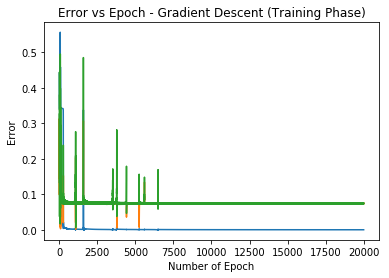

In [33]:
inst = NeuralNet(x_train, y_train, x_test, y_test)

def main():
    trmse = inst.train_nn()
    inst.predictClass()
    plt.plot(trmse)
    plt.xlabel("Number of Epoch")
    plt.ylabel("Error")
    plt.title("Error vs Epoch - Gradient Descent (Training Phase)")
    plt.legend()
    plt.show()
    
    #ax=plt.axes()
    #arr = metrics.confusion_matrix(inst.y_test, inst.test_pred, sample_weight=None)
    #con_df = pd.DataFrame(arr, columns = ["Predicted_0", "Predicted_1"], index=["Actual_0", "Actual_1"])
    #sns.heatmap(con_df, annot=True,annot_kws={"size": 8}, fmt='g', cmap='Blues', ax=ax)
    #ax.set_title('Confusion Matrix - Test Phase')
    #plt.show()
    #print('Test Accuracy: ', 1-np.sum(abs(inst.test_pred - inst.y_test))/inst.y_test.shape[0])
    #x = inst.sig[0].tolist()
    #y = inst.zvalue[0].tolist()
   
    
if __name__ == '__main__':
    main()

In [37]:
inst.test_pred

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.

In [38]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [224]:
inst.test_pred

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.